In [1]:
!pip install seqeval

In [2]:
!pip install sentencepiece

In [3]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

In [5]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [6]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)



test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

# 개체명 인식 학습 데이터 개수: 81000
# 개체명 인식 테스트 데이터 개수: 9000

train_ner_df.head()

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


In [7]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))
print(ner_labels)

개체명 인식 레이블 개수: 30
['UNK', 'O', 'PER-B', 'PER-I', 'FLD-B', 'FLD-I', 'AFW-B', 'AFW-I', 'ORG-B', 'ORG-I', 'LOC-B', 'LOC-I', 'CVL-B', 'CVL-I', 'DAT-B', 'DAT-I', 'TIM-B', 'TIM-I', 'NUM-B', 'NUM-I', 'EVT-B', 'EVT-I', 'ANM-B', 'ANM-I', 'PLT-B', 'PLT-I', 'MAT-B', 'MAT-I', 'TRM-B', 'TRM-I']


In [8]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

In [9]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

#         print(word)
        word_tokens = tokenizer.tokenize(word)
#         print(word_tokens)
        
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
#         print(tokens)
        
        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
            
#         print(label_ids)
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

#     print(sep_token_label_id)
    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

#     print(cls_token_label_id)
    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
#     print(label_ids)
    
    return label_ids

In [10]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [11]:
def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
#         print(labels)
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

        assert len(words) == len(labels_idx)

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

#         print("words=", words)
#         print("labels_idx=", labels_idx)
#         print("ner_begin_label=",ner_begin_label)
        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

#         print("convert_label_id=", convert_label_id)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)
#         break

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

In [12]:
train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
a = []
token = ['금', '##석', '##객', '##잔']
a.append(token)
print(a)
token = ['여러', '##분', ',']
a.append(token)
print(a)

[['금', '##석', '##객', '##잔']]
[['금', '##석', '##객', '##잔'], ['여러', '##분', ',']]


In [14]:
a = []
token = ['금', '##석', '##객', '##잔']
a.extend(token)
print(a)
token = ['여러', '##분', ',']
a.extend(token)
print(a)

['금', '##석', '##객', '##잔']
['금', '##석', '##객', '##잔', '여러', '##분', ',']


In [15]:
print(len(train_inputs[0][0]))
print(len(train_labels[0]))
print(train_inputs[0][0])
print(tokenizer.decode(train_inputs[0][0]))
for token in train_inputs[0][0]:
    print(tokenizer.decode(int(token)), end=" ")
    
print()
print(train_labels[0])
for label in train_labels[0]:
    print(ner_labels[label], end=" ")

111
111
[   101   8928  40958 118617 119196  30085  37712    117   8848  12945
  15001  35115  48345    119    102      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
[CLS] 금석객잔 여러분, 감사드립니다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [36]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")  # (32,111,768)(768,30) => (32,111,30) ??

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        

        return logits

In [38]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [39]:
a = tf.constant([[1,2,3],
                 [4,5,6]])
print(a)
a.get_shape().as_list()

tf.Tensor(
[[1 2 3]
 [4 5 6]], shape=(2, 3), dtype=int32)


[2, 3]

In [40]:
a = tf.constant([[1,2,3],
                 [4,5,0]])
print(a)
b = tf.reshape(a, (-1,))
print(b)
c = b != 0
print(c)

tf.Tensor(
[[1 2 3]
 [4 5 0]], shape=(2, 3), dtype=int32)
tf.Tensor([1 2 3 4 5 0], shape=(6,), dtype=int32)
tf.Tensor([ True  True  True  True  True False], shape=(6,), dtype=bool)


In [41]:
a = tf.constant([[[1,2,3],
                  [4,5,0]],
                 [[6,7,8],
                  [9,10,0]]]
                 )
print(a)
b = tf.reshape(a, (-1, a.get_shape().as_list()[2]))
print(b)

tf.Tensor(
[[[ 1  2  3]
  [ 4  5  0]]

 [[ 6  7  8]
  [ 9 10  0]]], shape=(2, 2, 3), dtype=int32)
tf.Tensor(
[[ 1  2  3]
 [ 4  5  0]
 [ 6  7  8]
 [ 9 10  0]], shape=(4, 3), dtype=int32)


In [42]:
labels = tf.constant([[1,2],
                      [4,0]])

active_loss = tf.reshape(labels, (-1,)) != 0
print(active_loss)

logits = tf.constant([[[1,2,3],
                       [4,5,6]],
                      [[6,7,8],
                       [9,10,11]]]
                       )
logits = tf.reshape(logits, (-1, logits.get_shape().as_list()[2]))
print(logits)
reduced_logits = tf.boolean_mask(logits, active_loss)
print(reduced_logits)

labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
print(labels)

tf.Tensor([ True  True  True False], shape=(4,), dtype=bool)
tf.Tensor(
[[ 1  2  3]
 [ 4  5  6]
 [ 6  7  8]
 [ 9 10 11]], shape=(4, 3), dtype=int32)
tf.Tensor(
[[1 2 3]
 [4 5 6]
 [6 7 8]], shape=(3, 3), dtype=int32)
tf.Tensor([1 2 4], shape=(3,), dtype=int32)


In [43]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    active_loss = tf.reshape(labels, (-1,)) != 0
        
#     reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
        
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, logits.get_shape().as_list()[2])), active_loss)
    
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
    return loss_fn(labels, reduced_logits)

In [44]:
labels = [['1', '1', '1', '1', '2', '2', '2']]
preds  = [['1', '1', '1', '1', '2', '2', '2']]
precision = precision_score(labels, preds, suffix=True)
print(precision)
recall = recall_score(labels, preds, suffix=True)
print(recall)

0.0
0.0


C:\ProgramData\Anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:167: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\ProgramData\Anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:167: UserWarning: 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\ProgramData\Anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

In [51]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [ ]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

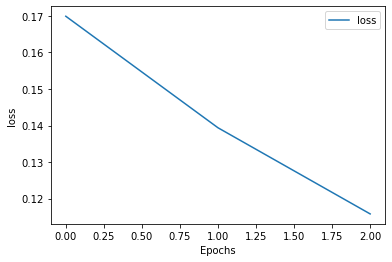

In [93]:
plot_graphs(history, 'loss')

In [94]:
ner_model.save_weights('weights_NER.h5')

In [52]:
ner_model.load_weights('weights_NER.h5')

In [61]:
print(test_inputs[0].shape)
print(test_inputs[0][0])
print(tokenizer.decode(test_inputs[0][0]))
for token in test_inputs[0][0]:
    print(tokenizer.decode(int(token)), end=" ")
    
print(test_labels[0])
for label in test_labels[0]:
    print(ner_labels[label], end=" ")    

(9000, 111)
[   101   8982  16985  11287   9954   9477  15184  11261  20308  11513
  23969   9672  11102 100699  10530  18154   9706 119285  12092  11506
    119    102      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
[CLS] 나아가 한 스트로크를 하는 제한시간에 대한 지침도 있다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [88]:
index=2
my_inputs = (test_inputs[0][index:index+1,:],test_inputs[1][index:index+1,:],test_inputs[2][index:index+1,:])
result = ner_model.predict(my_inputs)
print(result.shape)

for token in test_inputs[0][index]:
    print(tokenizer.decode(int(token), end=" "))
print()    

print(test_labels[index])
for label in test_labels[index]:
    print(ner_labels[label], end=" ")
    
print()
print('-'*100, end='\n')

active_loss = test_labels[index] != 0
reduced_logits = tf.boolean_mask(result[0], active_loss)

ner = np.argmax(reduced_logits, axis=1)
for label in ner:
    print(ner_labels[label], end=" ")

(1, 111, 30)
[ C L S ]
송
# # 인
# # 영
# # 은
5
# # 년
근
# # 화
# # 향
# # 에 서
개
# # 최
# # 된
C J
# # 나
# # 인
# # 브
# # 릿
# # 지
# # 클
# # 래
# # 식
토
# # 요
# # 돌
# # 봄
# # 으 로
'
L P
# # G A
직
# # 행
# # 티
# # 킷
'
을
거
# # 머
# # 쥐
# # 었 던
투
# # 표
# # 권
.
[ S E P ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]
[ P A D ]

[ 0  2  3  3  3 14 15 10 11 11 11  1  1  1 20 21 21 21 21 21 21 21 21 12
 13 13 13 13  8  9  9  